In [1]:
play = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from scipy.interpolate import interp1d

import utils as ut
import props as p
import lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)

#TIM = p.SpaceTIM
TIM = p.TIM
#TIM = p.TIM2
#GAL = p.AstroDeep
GAL = p.Euclid
CII = l.CII

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h

sigCoef = np.sqrt(8*np.log(2))
lilh = True

dlnk = 0.8

if play:
    dlnk = 1

colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

In [3]:
h

0.6766

In [4]:
# define our bins
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bin_zs = [b.center.value for b in bins]

bands = ['SW', 'SW', 'LW', 'LW'] 

print("TIM bins:")
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

TIM bins:
z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]


In [5]:
LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

for lsb in LSbins:
    print(lsb.cell_noise(TIM.time))

827101344741.0735 Jy2 Mpc3 / s2
1566381783187.4443 Jy2 Mpc3 / s2
747079853186.5887 Jy2 Mpc3 / s2
1144387987528.6865 Jy2 Mpc3 / s2


In [6]:
#Sanity check on the kscale of the bin LoS
for lsb in LSbins:
    print(np.around(lsb.LoS, 2), 'or k = ', np.around(2*np.pi / lsb.LoS, 4))

508.99 Mpc or k =  0.0123 1 / Mpc
439.17 Mpc or k =  0.0143 1 / Mpc
497.76 Mpc or k =  0.0126 1 / Mpc
416.27 Mpc or k =  0.0151 1 / Mpc


In [7]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

print(len(k_xyz_modes))
[print(kxyzs.shape) for kxyzs in k_xyz_modes]

4
(3, 20, 102, 39)
(3, 20, 102, 29)
(3, 15, 77, 39)
(3, 15, 77, 30)


[None, None, None, None]

In [8]:
# magnitudes of the k vectors
k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

# minimum k magnitude in each survey bin
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]

# unit kx, ky, kz vectors for each mode in each survey bin
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# num of k bins given our dlnk
num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
    for k_min, km in zip(k_mins, k_mags)]

num_kbins

C:\Users\juzz\AppData\Local\Temp\ipykernel_6956\2981313433.py:9: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


[13, 12, 12, 11]

In [9]:
# resolution elements Sigma_perpendicular (transverse) and sigma_par (LoS)
s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value / sigCoef for b, band in zip(bins, bands)]

In [10]:
s_perps

[0.11755244692217426,
 0.1516503189988713,
 0.24571221408768276,
 0.28908943552124405]

In [11]:
# outer product of the these three gaussians
windows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2)) 
                for kxyzs, s_perp, s_par in zip(k_xyz_modes, s_perps, s_pars)]

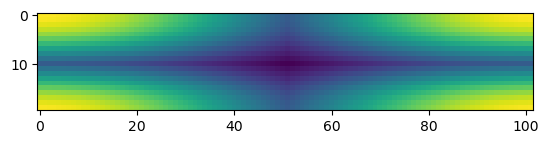

In [12]:
plt.figure()
plt.imshow(windows[0][:, :, 0])
plt.show()
plt.close()

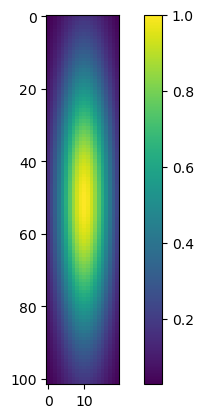

In [13]:
plt.figure()
plt.imshow(np.fft.fftshift(windows[0][:, :, 0]).T ** 2)
plt.colorbar()
plt.show()
plt.close()

In [14]:
# CAMB time, have to remove last redshift because there is a duplication
# and CAMB doesn't like that

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=False) 


results = camb.get_results(pars)

Note: redshifts have been re-sorted (earliest first)


In [15]:
bin_zs

[0.6435273234436414,
 0.8875998478508937,
 1.1728794218333967,
 1.4993660453911497]

In [16]:
binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
    for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]
print(z_idxs)

Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

[0, 1, 2, 2]


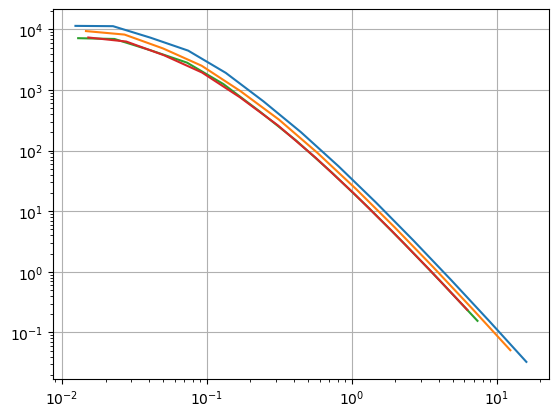

In [17]:
[plt.loglog(ks,Pm) for (ks, Pm) in Pms]
plt.grid()

In [18]:
kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
            for km, (ks, _) in zip(k_mags, Pms)]
# get bin edges by selecting the midway between each CAMB k prediction
# use geometric mean because bins are log-spaced

nModes = []
for j, (ks,ws) in enumerate(zip(k_mags, windows)):
    kflat = ks.flatten()
    wflat = ws.flatten()
    kNonZero = kflat[np.nonzero(kflat)[0]]
    edges = kbin_edges[j]
    
    nModeList = []
    for i in np.arange(len(edges)-1):
        #print(i, len(edges))
        if i+1 == len(edges):
            wSum = (np.sum(wflat[kflat>edges[i]]))
        else:
            wSum = (np.sum(wflat[(kflat>edges[i]) & (kflat<=edges[i+1])]))
        nModeList.append(wSum/2.) # accounting for double counting.
    nModeList = np.asarray(nModeList)
    nModes.append(np.asarray(nModeList))

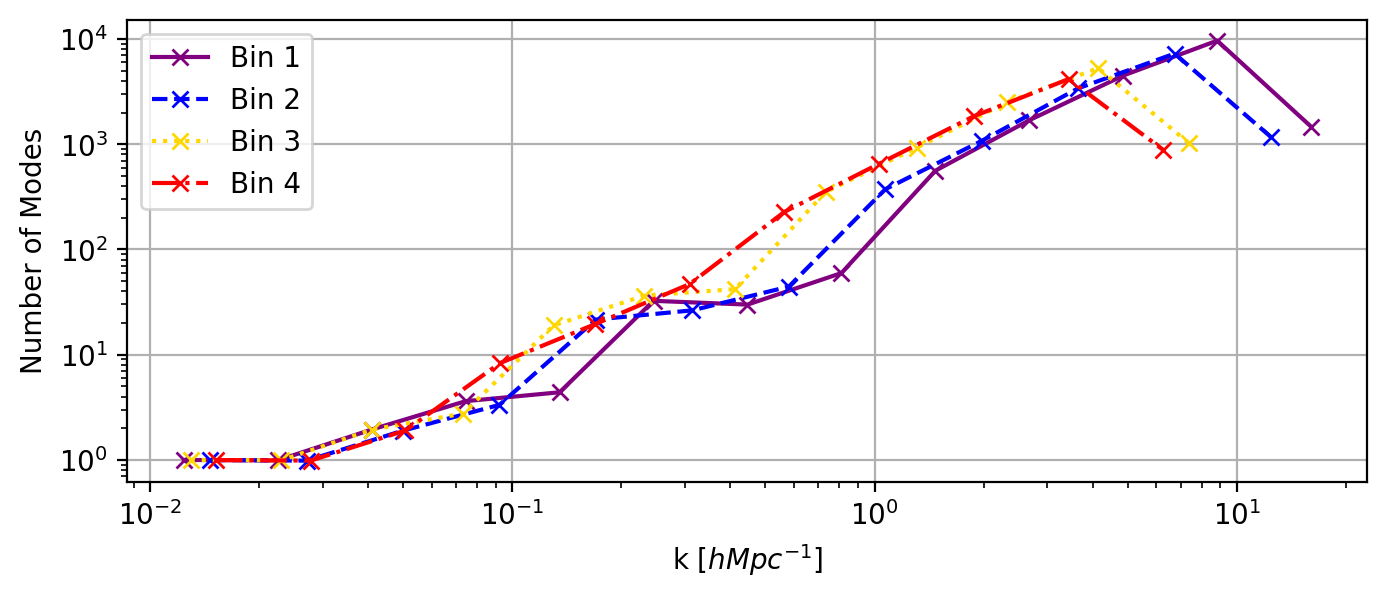

In [19]:
plt.figure(dpi = 200, figsize = (8,3))
for i,((ks,_),nums, col) in enumerate(zip(Pms,nModes, colors)):
    plt.loglog(ks,nums, color = col, linestyle = linestyles[i], marker = 'x', label = 'Bin ' + str(i+1))

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel('Number of Modes')

plt.grid()
plt.legend()

In [20]:
window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(windows, k_mags, kbin_edges)]

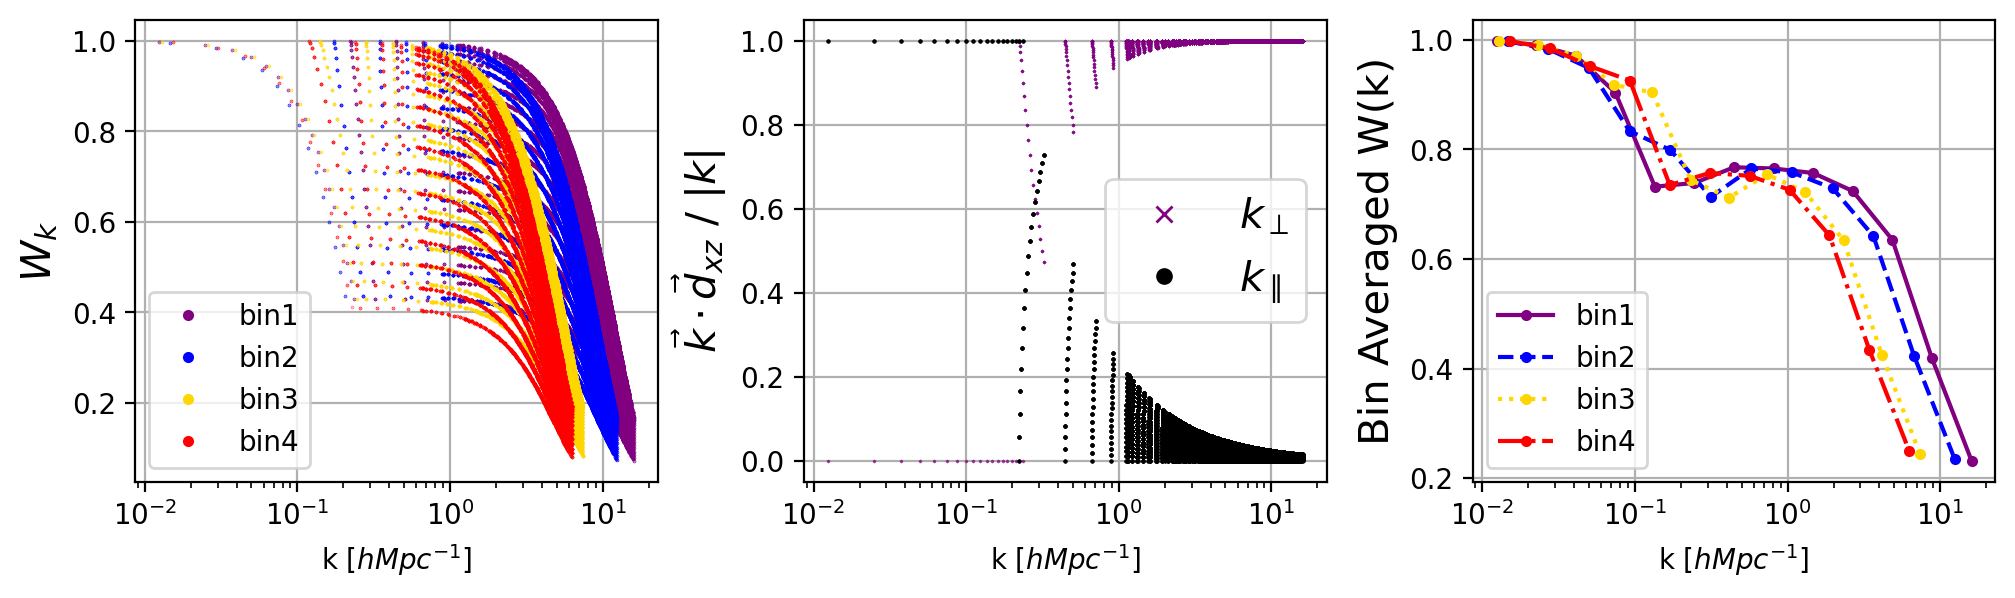

In [21]:
fig, (scatter, component, ave) = plt.subplots(1,3, figsize = (12,3), dpi = 200)#, sharex = True)

for i in range(len(k_mags)):
    scatter.semilogx(k_mags[i].flatten(), windows[i].flatten(), marker='.', \
    linestyle='None', label = 'bin'+str(i+1), markersize=.6, color = colors[i], alpha = .5)
scatter.grid()
scatterLeg = scatter.legend(markerscale = 10)
for lh in scatterLeg.legend_handles:
    lh.set_alpha(1)

for i in range(len(Pms)):
    ave.semilogx(Pms[i][0], window_avgs[i], label = 'bin'+str(i+1), marker='.', 
             color = colors[i], linestyle = linestyles[i] )
ave.grid()
ave.legend()
    

# making a plot for bin1
component.semilogx(k_mags[0].flatten(), (k_props[0][0] ** 2 + k_props[0][1] ** 2).flatten(), marker='x',
               linestyle='None', markersize=.6, alpha = 0.5, label = r'$k_{\perp}$', color = 'purple')
component.semilogx(k_mags[0].flatten(), k_props[0][2].flatten(), marker='.', linestyle='None', 
               markersize=1, label = r'$k_{\parallel}$', color = 'black')
component.grid()
compLeg = component.legend(fontsize = 15, markerscale = 10)
for lh in compLeg.legend_handles:
    lh.set_alpha(1)
#compLeg.legendHandles[0]._legmarker.set_markersize(6)
#compLeg.legendHandles[1]._legmarker.set_markersize(6)

scatter.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
component.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
ave.set_xlabel(r"k [$h Mpc^{-1}]$", size=10)

component.set_ylabel(r'$ \vec{k} \cdot \vec{d}_{xz}$ / $|k|$', fontsize = 15)
scatter.set_ylabel(r'$W_k$', fontsize = 15)
ave.set_ylabel('Bin Averaged W(k)', fontsize = 15)
fig.subplots_adjust(hspace=0, wspace=0.28)

In [22]:
sfrds = [ut.MD_sfrd(z) for z in bin_zs]
Iciis = np.array([CII.Inu(sfrd, z).value for sfrd, z in zip(sfrds, bin_zs)])

In [23]:
fs = 0.897 #Proportion of Galaxy sample galaxies that are line emitters
#TODO- Juzz - Recall where we got this number.
b_CII = 1.7 # TODO: Get an actual value for this and Bgal
b_gal = 1.7 # maintaining b* = b_CII*b_gal = 3
Igal = 1
bstar = b_CII*b_gal

x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
#where fs is SFRD from the catalogue divided by the corresponding madau dickinson curve point.
PxGs = [(bstar * Icii * Igal * Pm) + x_shot 
            for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]
#num_modes = [np.histogram(km, kb)[0] for km, kb in zip(k_mags, kbin_edges)]

In [24]:
x_shots

array([147619.42691558, 236401.48333171, 353953.75946212, 521982.50630284])

The following cell will calculate CII auto power spectra and galaxy survey auto power to use in the $\sigma_P$ calculation.
Here $\sigma_P \equiv \sqrt{VAR[P_x]}$:

$$VAR[P_x] = \frac{1}{2N_{mode}} [P^2_x + (P_{[CII]} + \frac{P_N}{W}) \cdot (P_{Gal} + \frac{1}{n_{gal}})]$$

OR

$$VAR[P_x] = \frac{1}{2N_{mode}} [P^2_x + (P_N + P_{[CII]}) \cdot (P_{Gal} + \frac{1}{n_{gal}})]$$
but where $$N_{mode} = \int dk^3 W_{TIM}(k_x, k_y, k_z) \cdot W_{GAL}(k_x, k_y, k_z) $$

So, an issue: here the dk cubed gives units of inverse volume where Nmodes should be unitless. Should there be some normalization here that cancels the volume units?

~*Breysse and Alexandroff 2019*

In [25]:
#### Trying to add in variance terms


TIM_shot = [1.2e9,2.2e9,3e9,3e9] # TODO: Discuss a self consistent way of calculating these values.

P_TIM = [(b_CII**2 * ICII**2 * Pm + shot) for ICII, (_,Pm), shot in zip(Iciis, Pms, TIM_shot)]

N_TIM = [lsb.cell_noise(TIM.time).value for lsb, nm in zip(LSbins, nModes)]
P_gal = [b_gal**2*Pm for (_,Pm), ngal in zip(Pms, GAL.n_gals)]
SNR_TIM = [PT/NT for PT, NT in zip(P_TIM, N_TIM)] #This needs some nm and w factors added.

In [26]:
def galCross_Variance(ngal, numModes, Px, Pg, Pl, Nl):
    crossVar = [(PxG**2 + (NT + PT) * (1/n_gal +Pg)) / (2*nm)
        for n_gal, nm, PxG, Pg, PT, NT in zip(ngal, numModes, Px, Pg, Pl, Nl)]
    return crossVar

In [27]:
VARx = galCross_Variance(GAL.n_gals, nModes, PxGs, P_gal, P_TIM, N_TIM)
SNR_PxG = [PxG / np.sqrt(VARs)  for PxG, VARs in zip(PxGs, VARx)]

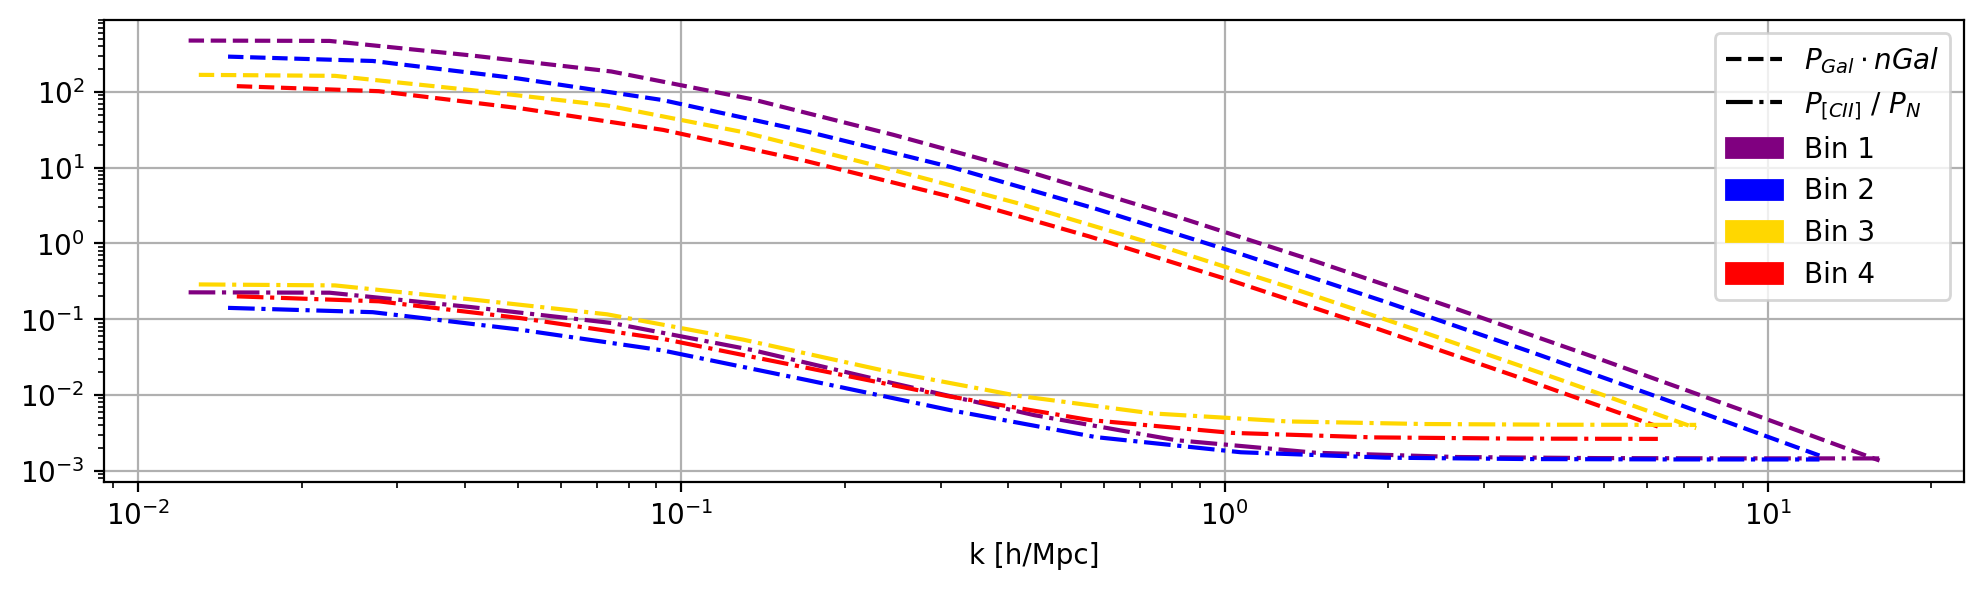

In [28]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.figure(dpi = 200, figsize = (12,3))
[plt.loglog(ks, Pg/ (1/ng), color = colors[i], ls = '--', label = r'P_{Gal} nGal') for i,((ks,_), Pg, ng) in enumerate(zip(Pms, P_gal, GAL.n_gals))]
#[plt.loglog(ks, SNRPxG, color = colors[i]) for i,((ks,_), SNRPxG) in enumerate(zip(Pms, SNR_PxG))]
[plt.loglog(ks, PT/NT, color = colors[i], ls = '-.', label = r'$P_{[CII]} / P_N$') 
     for i,((ks,_), PT, NT) in enumerate(zip(Pms, P_TIM, N_TIM))]
#[plt.axhline(1/ng, color = colors[i], ls = ':') for i,ng in enumerate(GAL.n_gals)]
#[plt.axhline(NT, color = colors[i], ls = '-.') for i,NT in enumerate(N_TIM)]

#dash = mpatches.Patch(color='black', ls = '--', label=r'$P_{Gal} nGal$')

plt.xlabel('k [h/Mpc]')
dash = mlines.Line2D([], [], color='black', marker='', ls = '--', label=r'$P_{Gal} \cdot nGal$')
dashDot = mlines.Line2D([], [], color='black', marker='', ls = '-.', label= r'$P_{[CII]}$ / $P_N$')
purple = mpatches.Patch(color='purple', label='Bin 1')
blue = mpatches.Patch(color='blue', label='Bin 2')
gold = mpatches.Patch(color='gold', label='Bin 3')
red = mpatches.Patch(color='red', label='Bin 4')

plt.legend(handles=[dash, dashDot, purple, blue, gold, red])
#plt.legend(handles=[dashDot])
plt.grid()

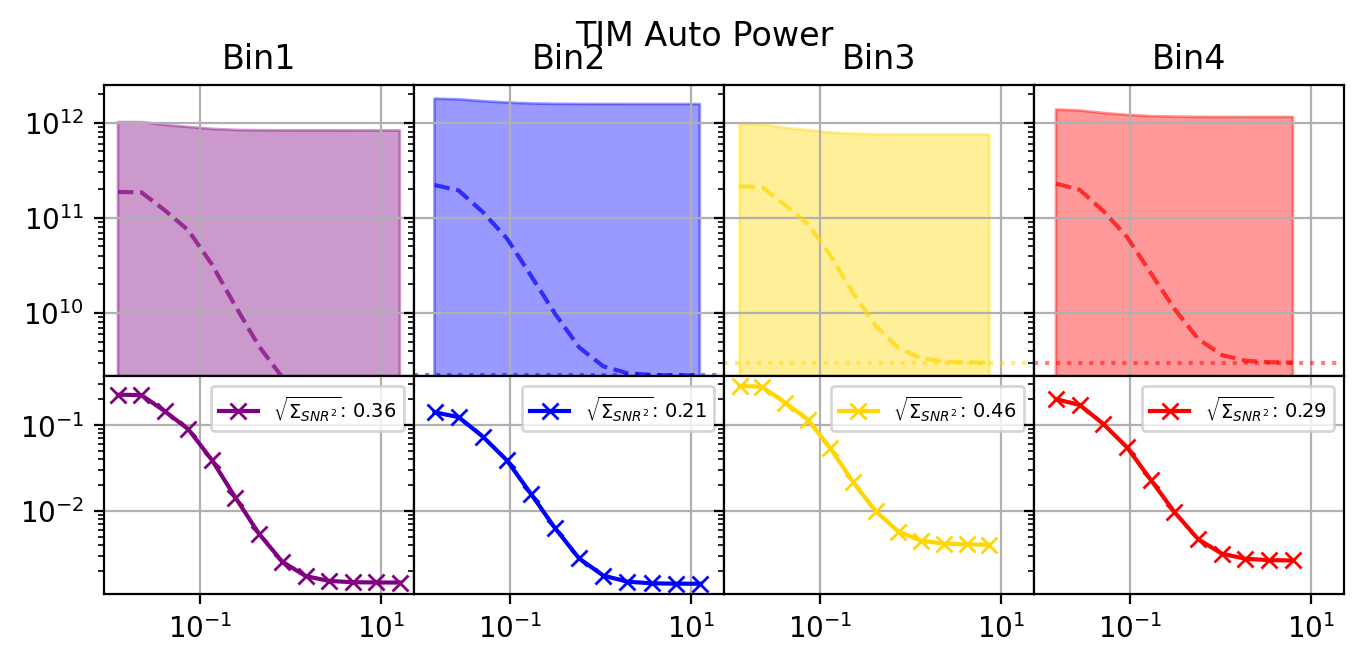

In [29]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)
quad_SNR_TIM = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_TIM]

for i, PT in enumerate(P_TIM):
    power[i].loglog(Pms[i][0], PT, color = colors[i], linestyle = '--', alpha = .7)
    power[i].axhline(TIM_shot[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PT + N_TIM[i],
                   PT - N_TIM[i], color = colors[i], alpha = .4)
    power[i].set_title('Bin'+str(i+1))

    SNR[i].loglog(Pms[i][0], SNR_TIM[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNR_TIM[i],2)))
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    #SNR[i].set_yticks(np.arange(0, 26, 4.0))

fig.subplots_adjust(hspace=0, wspace=0)

fig.suptitle('TIM Auto Power')
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

In [30]:
#CAMB outputs lists of different ks for each bin so we can't sum them 'apples to apples.'
#So, we'll interpolate Cross powers, SNRs and noise values at matching ks across all bins.

PxG_Interp = [interp1d(ks, PxG) for (ks, _), PxG in zip(Pms, PxGs)]
SNR_PxG_Interp = [interp1d(ks, SNR) for (ks, _), SNR in zip(Pms, SNR_PxG)]
x_noise_Interp = [interp1d(ks, np.sqrt(VARs)) for (ks, _), VARs in zip(Pms, VARx)]

k4 = Pms[3][0] #isolate the list of k modes in bin 4. We'll use that as our default k list. 
aligned_PxGs = [interp(k4) for interp in PxG_Interp] #Interpolate the forecast signals in all bins at the modes in k4.
aligned_SNRs = np.nan_to_num([interp(k4) for interp in SNR_PxG_Interp]) #same for SNRs - nanToNum sets NaNs = 0.
aligned_x_noises = [interp(k4) for interp in x_noise_Interp]#and x_noises.

In [31]:
#sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
quad_SNRs = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_PxG]

#now sum each k as it is measured in each bin so we can report the total SNR per k bin.
SNR_by_k = np.zeros(len(aligned_SNRs[0]))
for SNRks in aligned_SNRs: SNR_by_k += SNRks**2
totQuadSNR = np.sqrt(np.sum(SNR_by_k))

In [32]:
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]


C:\Users\juzz\AppData\Local\Temp\ipykernel_6956\840086503.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


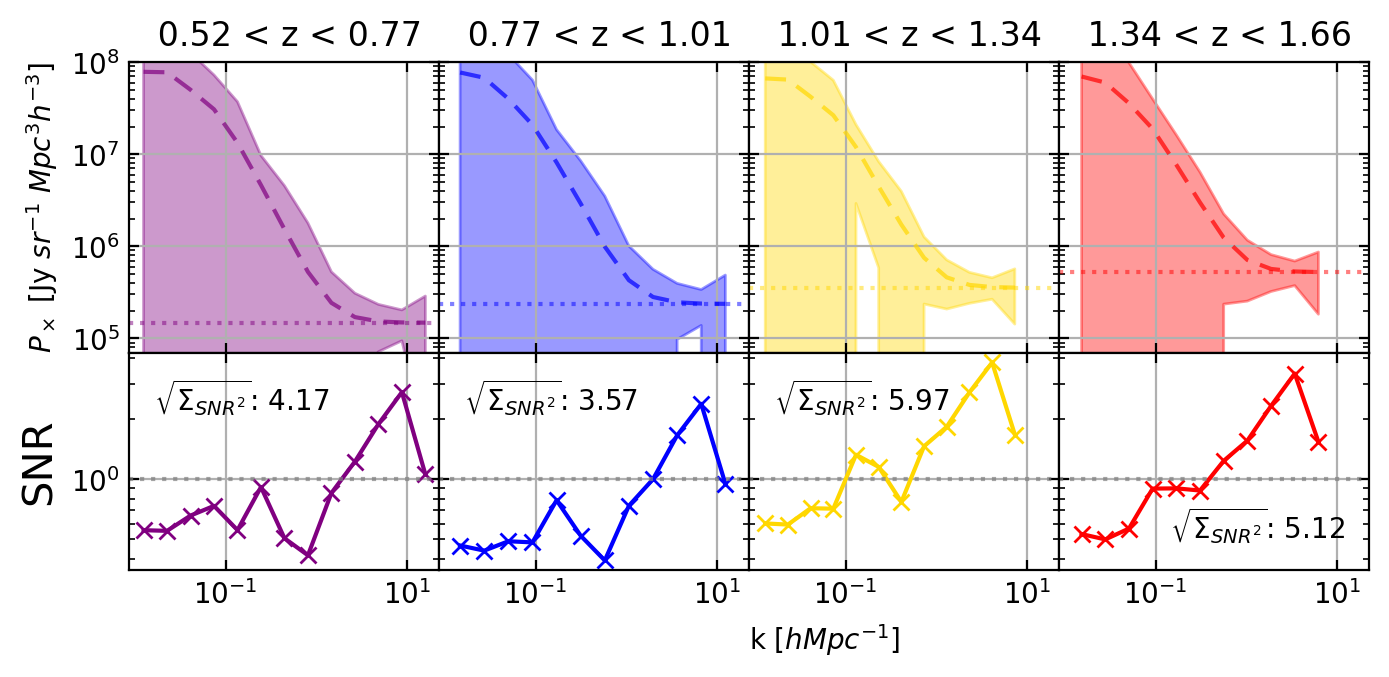

In [33]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(PxGs):
    power[i].loglog(Pms[i][0], PxG, color = colors[i], linestyle = '--', alpha = .7)
    power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PxG + np.sqrt(VARx[i]),
                   PxG - np.sqrt(VARx[i]), color = colors[i], alpha = .4)
    #power[i].set_title('Bin'+str(i+1))
    power[i].set_title(f" {bins[i].front:.2f} < z < {bins[i].back:.2f}")

    SNR[i].loglog(Pms[i][0], SNR_PxG[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNRs[i],2)))
    SNR[i].axhline(1, color = 'grey', ls = ":", alpha = .7)
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    #SNR[i].set_yticks(np.arange(0, 26, 4.0))
    leg = SNR[i].legend(prop={'size': 10}, handlelength=0, handletextpad=0, fancybox=True, loc = 'best')
    for item in leg.legendHandles:
        item.set_visible(False)

power[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 10)
power[0].set_ylim(7e4,1e8)

SNR[0].set_ylabel(r"SNR", size = 15)
#power[0].set_xlim(1.2e-1, 0.1e2)

#power[0].set_ylim(1e5, 1e7)
#SNR[0].set_ylim(0,25)
SNR[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10, loc = 'left')
fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

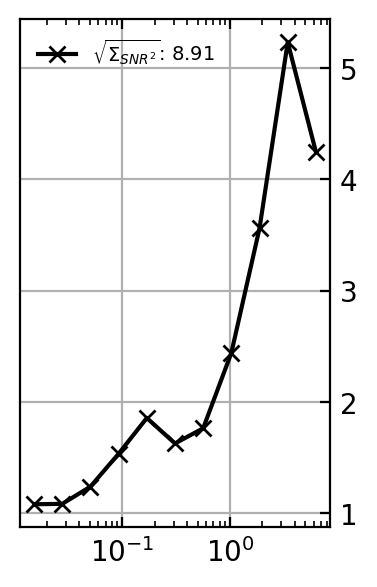

In [34]:
fig, total = plt.subplots(1,1, dpi = 200, figsize = (2,3.3))
total.semilogx(k4, np.sqrt(SNR_by_k), color = 'black', marker = 'x', 
        label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(totQuadSNR,2)))
total.grid()
total.legend(fontsize = 7)
total.yaxis.tick_right()

In [35]:
def quadsum(arr):
    return np.sqrt(np.sum(arr[~np.isnan(arr)]**2))

In [36]:
nGalList = np.logspace(-5, -2, 50)
SNRx_as_nGal = np.zeros(len(nGalList))

for i,n in enumerate(nGalList):
    x_shot = fs * Iciis[2] / n # cross shot for TIMxGal
    Pcross = (bstar * Iciis[2] * Igal * Pms[2][1]) + x_shots[2]
    
    VARxTIM = (Pcross**2 + (N_TIM[2] + P_TIM[2]) * (1/n +P_gal[2])) / (2*nModes[2])
    
    SNRx_as_nGal[i] = quadsum(Pcross / np.sqrt(VARxTIM))

In [37]:
save = False

if save: np.save('SNRx_as_nGal_TIM_Space', SNRx_as_nGal )

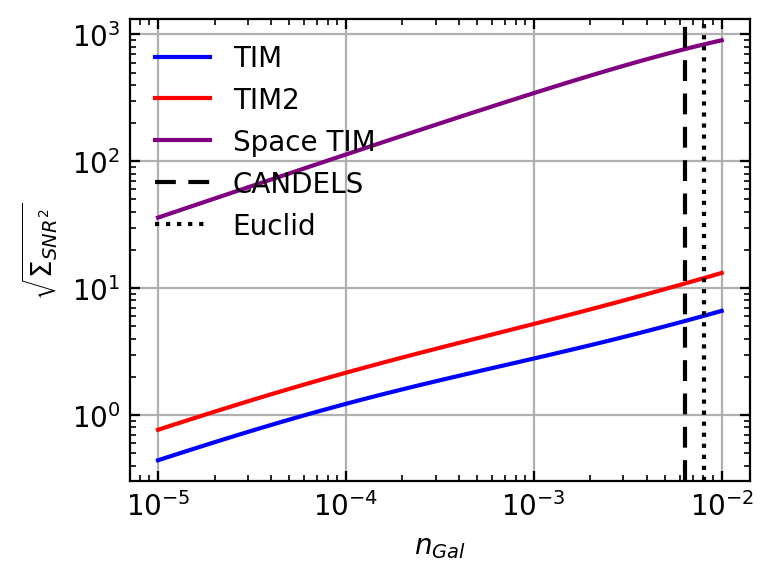

In [38]:
plt.figure(dpi = 200, figsize = (4,3))

TIM1 = np.load('SNRx_as_nGal_TIM_Vanilla.png.npy')
TIM2 = np.load('SNRx_as_nGal_TIM_Double_detector.npy')
TIMSpace = np.load('SNRx_as_nGal_TIM_Space.npy')

plt.loglog(nGalList, TIM1, label = 'TIM', ls = '-', color = 'blue')
plt.loglog(nGalList, TIM2, label = 'TIM2', ls = '-', color = 'red')
plt.loglog(nGalList, TIMSpace, label = 'Space TIM', ls = '-', color = 'purple')

plt.axvline(p.AstroDeep.n_gals[2], label = 'CANDELS', ls = '--', color = 'black')
plt.axvline(p.Euclid.n_gals[2], label = 'Euclid', ls = ':', color = 'black')

plt.xlabel(r'$n_{Gal}$')
plt.ylabel(r'$\sqrt{\Sigma_{SNR^2}}$')

plt.legend()
plt.grid()

In [39]:
#LWNEIARR = np.loadtxt('../TIM_LW_loading_space_4.5K.tsv')
#SWNEIARR = np.loadtxt('../TIM_SW_loading_space_4.5K.tsv')

In [40]:
#TIM.SW.NEI

In [41]:
#plt.loglog(LWNEIARR[:,0], LWNEIARR[:,2])
#plt.loglog(SWNEIARR[:,0], SWNEIARR[:,2])

#plt.grid()


In [42]:
#LWNEI = LWNEIARR[:,2].mean()
#SWNEI = SWNEIARR[:,2].mean()

#print('LW NEI: ', LWNEI)
#print('SW NEI: ', SWNEI)

In [43]:
spaceSig = []
spaceks = []
TIM2Sig = []
TIM2ks = []
#TIMSig = []
spaceSig.append([np.asarray(np.load('TIMSpace_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
spaceks.append([np.asarray(np.load('TIMSpace_k_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
TIM2Sig.append([np.asarray(np.load('TIM2_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])
TIM2ks.append([np.asarray(np.load('TIM2_k_bin'+str(i+1)+'.npy')) for i in np.arange(4)])

#TIMSig.append([np.asarray(np.load('TIM2_sig_bin'+str(i+1)+'.npy')) for i in np.arange(4)])


In [44]:
spaceSig

[[array([6.20472936e+15, 6.19443611e+15, 1.40529287e+15, 5.29124687e+13,
         2.04683414e+12, 6.70285447e+10, 2.62536025e+09, 1.27787320e+08,
         1.20063473e+07, 3.13230457e+06, 1.64060644e+07]),
  array([6.02731169e+15, 4.79666826e+15, 1.45602511e+14, 1.21143015e+13,
         3.01663948e+11, 1.20972230e+10, 5.66455000e+08, 4.64926345e+07,
         1.06347986e+07, 5.21495537e+07]),
  array([4.51410722e+15, 4.34863482e+15, 2.46914924e+14, 2.06687724e+13,
         7.79765149e+11, 3.65926790e+10, 2.08168475e+09, 2.12409035e+08,
         5.28681743e+07, 3.03445212e+08]),
  array([4.98560694e+15, 3.81256849e+15, 5.44687609e+13, 4.32508424e+12,
         1.47147827e+11, 7.35159781e+09, 6.31292608e+08, 1.32869247e+08,
         6.87127267e+08])]]

In [45]:
len(spaceSig[0][0])

11

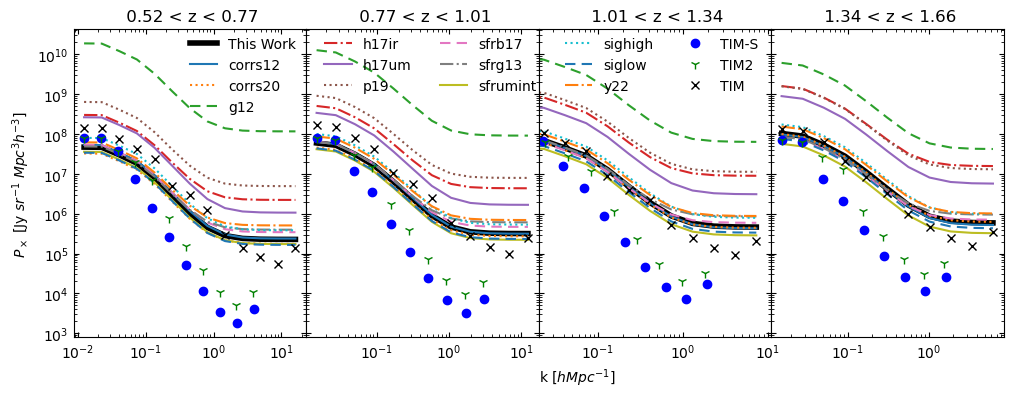

In [46]:
modelList = os.listdir('./Model_Params_from_simim/')

fig, plots = plt.subplots(1,4, figsize = (12,4), sharey = True)
lsList = ['-', ':', '--', '-.']
mkList = ['o', 'x']
count = 0

for model in modelList:
        
    model_params = np.loadtxt('./Model_Params_from_simim/'+model, delimiter=',')
    modelP = model_params[:,7]
    modelShot = model_params[:,8]
    ModelPx = [xPow*Pm + shot for xPow, (_,Pm), shot in zip(modelP, Pms, modelShot)]
    
    if model == 'juzz_data_model_lcii.npy':
        [plots[i].loglog(ks, Px, label = 'This Work', color = 'black', lw = 4) 
         for i, ((ks,_), Px) in enumerate(zip(Pms, ModelPx))]
        continue
    tag = model.replace('juzz_data_model_lcii_', '').replace('.npy','')
    if count >= len(lsList): count = 0
    
    [plots[i].loglog(ks, Px, label = tag, ls = lsList[count]) 
     for i, ((ks,_), Px) in enumerate(zip(Pms, ModelPx))]
    count += 1

    
for i in np.arange(0,4):
    plots[i].loglog(spaceks[0][i], np.sqrt(spaceSig[0][i]), marker = 'o', label = 'TIM-S', color = 'blue', ls = '')
    plots[i].loglog(TIM2ks[0][i], np.sqrt(TIM2Sig[0][i]), marker = '1', label = 'TIM2', ms = 7, color = 'green',ls = '')
    plots[i].set_title(f" {bins[i].front:.2f} < z < {bins[i].back:.2f}")
    
    
    
[plots[i].loglog(ks, np.sqrt(VARs), ls = '', marker = 'x', color = 'black', label = 'TIM') 
         for i, (VARs, (ks,_)) in enumerate(zip(VARx, Pms))]


plots[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10, loc = 'left')
plots[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 10)
plots[2].set_xlim(2e-2,1.1e1)

plots[3].legend(loc='center right', bbox_to_anchor=(0.0, 0.85),
      ncol=5, fancybox=True, shadow=False)
fig.subplots_adjust(hspace=0, wspace=0)

In [ ]:
Plot cosmic variance 

In [47]:
saveSig = False
if saveSig:
    for i in [1,2,3,4]:
        np.save('TIMSpace_sig_bin' + str(i) + '.npy', VARx[i-1])
        np.save('TIMSpace_k_bin' + str(i) + '.npy', Pms[i-1][0])

[[<matplotlib.lines.Line2D at 0x279cfe2ca50>],

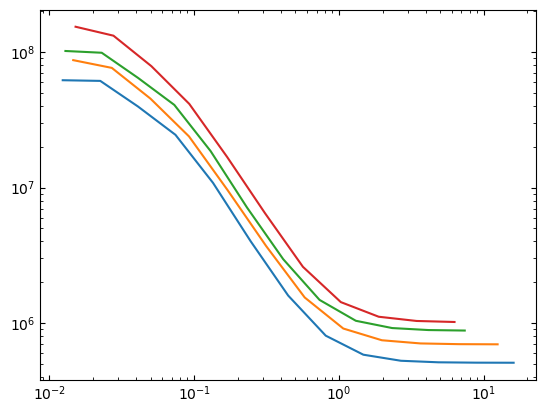

In [48]:
[plt.loglog(ks, Px) for (ks,_), Px in zip(Pms, ModelPx)]

In [49]:
midks = Pms[2][0]
midPm = Pms[2][1]

In [50]:
VARx*3

[array([1.99406108e+16, 1.97841879e+16, 5.80257720e+15, 1.74841311e+15,
        5.69989115e+14, 2.55792840e+13, 9.11315315e+12, 1.59547817e+12,
        8.10077553e+10, 1.92968445e+10, 6.58282475e+09, 2.99601089e+09,
        1.96109580e+10]),
 array([2.74366124e+16, 2.36864264e+16, 6.67433423e+15, 1.86116430e+15,
        1.07672046e+14, 3.10622270e+13, 6.35485080e+12, 3.36536233e+11,
        7.90303572e+10, 2.21848326e+10, 1.00870889e+10, 6.23687397e+10]),
 array([1.22762236e+16, 1.18684183e+16, 3.45132610e+15, 1.38355185e+15,
        8.15699937e+13, 1.49881253e+13, 4.97339997e+12, 2.63913786e+11,
        6.32954323e+10, 1.97109513e+10, 8.88964798e+09, 4.52884792e+10]),
 array([1.72361634e+16, 1.43853329e+16, 3.98058636e+15, 4.41996828e+14,
        7.29083908e+13, 1.16149006e+13, 1.01035435e+12, 2.07676543e+11,
        5.98315830e+10, 2.50420121e+10, 1.16681456e+11]),
 array([1.99406108e+16, 1.97841879e+16, 5.80257720e+15, 1.74841311e+15,
        5.69989115e+14, 2.55792840e+13, 9.113153

In [51]:
len(Pms[0][1])

13

In [52]:
[print(len(var)) for var in VARx]

13
12
12
11


[None, None, None, None]

In [53]:
len(np.load('TIMSpace_sig_bin4.npy'))

9

In [54]:
for i in [1,2,3,4]:
    print(len(VARx[i-1]))

13
12
12
11


In [55]:
np.load('TIMSpace_sig_bin4.npy')

array([4.98560694e+15, 3.81256849e+15, 5.44687609e+13, 4.32508424e+12,
       1.47147827e+11, 7.35159781e+09, 6.31292608e+08, 1.32869247e+08,
       6.87127267e+08])